<a href="https://colab.research.google.com/github/fx-manmeet/learn-ml-repo/blob/main/Pretrained_feature_extraction_fine_tuining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transfer Learning
* Feature Extraction
* Fine tuining

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import tensorflow_datasets as tfds

In [ ]:
#tfds.disable_progress_bar()  #to stop displaying process of dataset creation

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.1.incompleteTUO41F/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [ ]:
print(tf.data.experimental.cardinality(train_ds))
print(tf.data.experimental.cardinality(validation_ds))
print(tf.data.experimental.cardinality(test_ds))

tf.Tensor(9305, shape=(), dtype=int64)
tf.Tensor(2326, shape=(), dtype=int64)
tf.Tensor(2326, shape=(), dtype=int64)


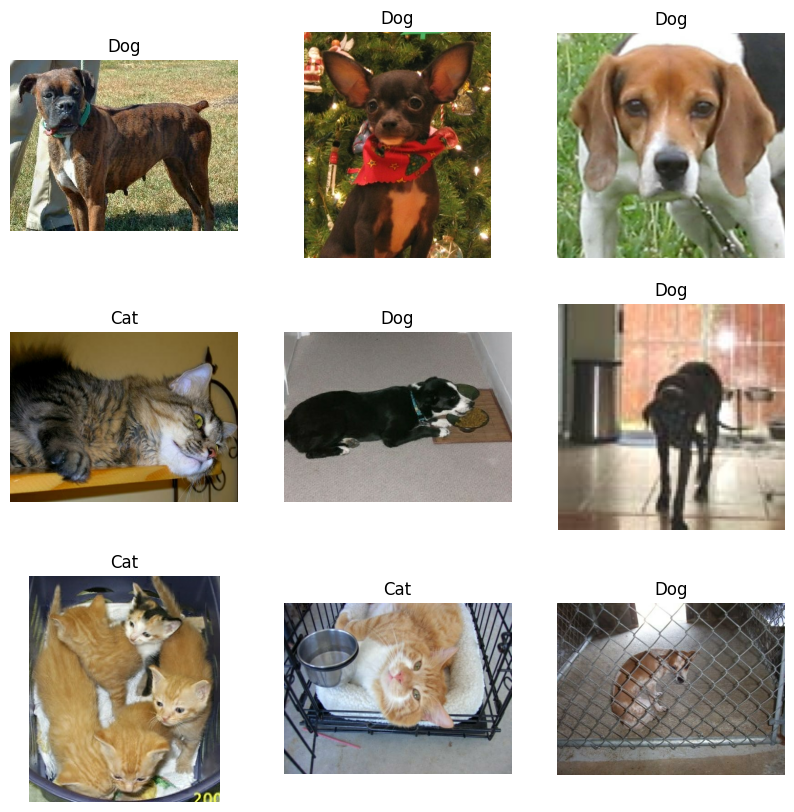

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title('Cat' if int(label) == 0 else 'Dog')
    plt.axis("off")

In [ ]:
size = (150,150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x,size),y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x,size),y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x,size),y))

####To optimize the training we will batch, cache and prefetch the dataset.

In [ ]:
batch_size=32
buffer_size=10

train_ds = train_ds.cache().batch(batch_size=batch_size).prefetch(buffer_size=buffer_size)
validation_ds = validation_ds.cache().batch(batch_size=batch_size).prefetch(buffer_size=buffer_size)
test_ds = test_ds.cache().batch(batch_size=batch_size).prefetch(buffer_size=buffer_size)

####Introduce data augmentation

In [ ]:
from keras import layers

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

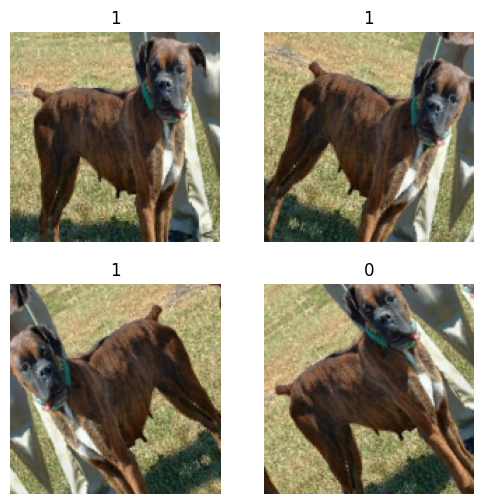

In [ ]:
for images, labels in train_ds.take(1):      #visualize augmentation
    plt.figure(figsize=(6, 6))
    first_image = images[0]
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[i]))
        plt.axis("off")

###Xception pretrained modelis our base model

####Feature Extraction

In [ ]:
base_model = keras.applications.Xception(
              weights='imagenet',
              input_shape = (150,150,3),
              include_top=False
)
base_model.trainable=False                      #for feature extractor

inputs =keras.Input(shape=(150,150,3))
x=data_augmentation(inputs)

#normalize before feeding it to base model
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)  #sets value between [-1,1]
x= scale_layer(x)
x= base_model(x, training=False)
x= keras.layers.GlobalAveragePooling2D()(x)
x= keras.layers.Dropout(0.2)(x)
outputs= keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0      

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 5
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/5
291/291 [==============================] - 30s 83ms/step - loss: 0.1035 - binary_accuracy: 0.9589 - val_loss: 0.0736 - val_binary_accuracy: 0.9712
Epoch 2/5
291/291 [==============================] - 23s 81ms/step - loss: 0.0999 - binary_accuracy: 0.9585 - val_loss: 0.0898 - val_binary_accuracy: 0.9630
Epoch 3/5
291/291 [==============================] - 23s 80ms/step - loss: 0.1009 - binary_accuracy: 0.9593 - val_loss: 0.0742 - val_binary_accuracy: 0.9725
Epoch 4/5
291/291 [==============================] - 24s 82ms/step - loss: 0.0952 - binary_accuracy: 0.9614 - val_loss: 0.0715 - val_binary_accuracy: 0.9721
Epoch 5/5
291/291 [==============================] - 23s 80ms/step - loss: 0.0969 - binary_accuracy: 0.9589 - val_loss: 0.0713 - val_binary_accuracy: 0.9725


In [ ]:
import requests

# URL of the image you want to download
image_url = "https://images.pexels.com/photos/45201/kitty-cat-kitten-pet-45201.jpeg?auto=compress&cs=tinysrgb&w=600"

# Send a GET request to the URL to fetch the image data
response = requests.get(image_url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Save the image data to a file
    with open("image.jpg", "wb") as file:
        file.write(response.content)
    print("Image downloaded successfully.")
else:
    print("Failed to download the image. Status code:", response.status_code)


Image downloaded successfully.


In [ ]:
from tensorflow.keras.preprocessing import image

img_path = "image.jpg"
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img)  # Convert PIL image to numpy array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

img_array = img_array / 127.5 - 1

#inference
predictions = model.predict(img_array)

# Post-processing the prediction
if predictions[0] >= 0.5:
    print("It's a dog!")
else:
    print("It's a cat!")

1/1 [==============================] - 2s 2s/step
It's a cat!


###Fine-tuining

In [ ]:
#here we unfreze the trainable parameters od the base model but yet train it in very low learning rate
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 1
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

In [ ]:
#inference fine-tuining
predictions = model.predict(img_array)

# Post-processing the prediction
if predictions[0] >= 0.5:
    print("It's a dog!")
else:
    print("It's a cat!")

1/1 [==============================] - 1s 1s/step
It's a cat!
